# Spectral simulations with gammapy


### Objective

Simulate a number of spectral on-off observations of a source with a power-law spectral model using the CTA 1DC response and fit them with the assumed spectral model.

### Steps

* Create a fake observation of the Crab using CTA alpha configuration and build a 1D spectrum dataset for this observation
* Fake multiple times a log-parabola source spectrum with ON-OFF statistic and fit it and to measure the statistcal uncertainty expected

In [1]:
# General imports
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from regions import CircleSkyRegion
import matplotlib.pyplot as plt 

In [2]:
from gammapy.irf import load_irf_dict_from_file

In [3]:
irfs = load_irf_dict_from_file(
    "$GAMMAPY_DATA/cta-caldb/Prod5-South-20deg-AverageAz-14MSTs37SSTs.180000s-v0.1.fits.gz"
)

In [4]:
print(irfs)

{'aeff': <gammapy.irf.effective_area.EffectiveAreaTable2D object at 0x7d43a7965600>, 'psf': <gammapy.irf.psf.parametric.EnergyDependentMultiGaussPSF object at 0x7d43a7965f00>, 'edisp': <gammapy.irf.edisp.core.EnergyDispersion2D object at 0x7d43a79674c0>, 'bkg': <gammapy.irf.background.Background3D object at 0x7d43a79b2140>}


In [5]:
offset=[0.5]*u.deg

<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Effective Area [$\\mathrm{m^{2}}$]'>

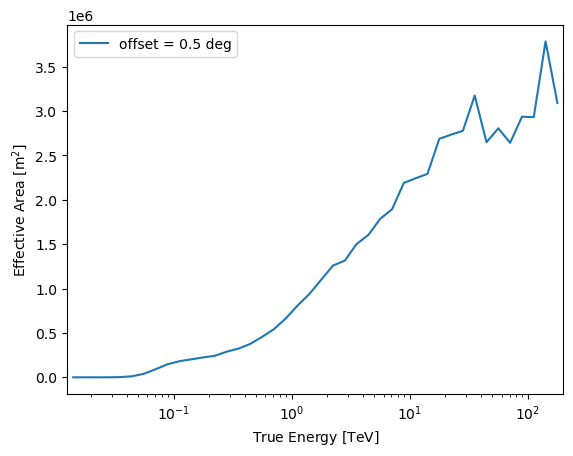

In [6]:
irfs['aeff'].plot_energy_dependence(offset=offset)

<Axes: xlabel='True Energy [$\\mathrm{TeV}$]', ylabel='Containment radius [$\\mathrm{{}^{\\circ}}$]'>

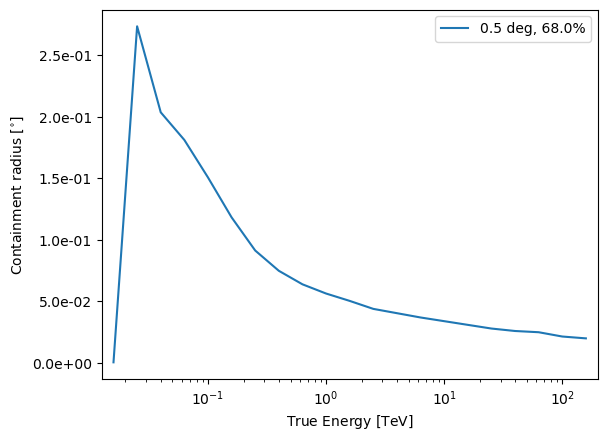

In [7]:
irfs['psf'].plot_containment_radius_vs_energy(offset=offset, fraction=[0.68])

### Define pointing positions

For this tutorial we are interested in the crab

In [8]:
from gammapy.data import Observation, FixedPointingInfo, observatory_locations

In [9]:
target = SkyCoord.from_name('crab')

pointing = FixedPointingInfo(
    fixed_icrs=SkyCoord(target.ra, target.dec, frame="icrs"),
)

In [10]:
livetime = 3*u.hr
location = observatory_locations["cta_south"]

obs = Observation.create(
    pointing=pointing,
    livetime=livetime,
    irfs=irfs,
    location=location,
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.12
	duration          : 10800.00 s
	pointing (icrs)   : 83.6 deg, 22.0 deg

	deadtime fraction : 0.0%



## Defining the reduced dataset geometry

We prepare the 1D spectra geometry. We need to provide the binning in reco and true energy, for the counts, counts_off and the IRFs.

We take a region of 0.1 degree around the Crab nebula

Note: the `Geom` is a generic object that can contain different types of data

In [11]:
from gammapy.maps import MapAxis, Map, RegionGeom
from gammapy.datasets import SpectrumDataset, Datasets, SpectrumDatasetOnOff
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker

In [12]:
# Reconstructed and true energy axis
energy = MapAxis.from_energy_bounds(0.05, 100, 5, unit='TeV', per_decade=True)
energy_true = MapAxis.from_energy_bounds(0.025, 200, 10, unit='TeV', per_decade=True, name="energy_true")

on_region_radius = 0.1*u.deg
on_region = CircleSkyRegion(center=target, radius=on_region_radius)
geom = RegionGeom.create(on_region, axes=[energy])

#### Instantiate the data reduction Makers
- SpectrumDatasetMaker projects the events and IRF in the correct geometry. 
- We don't create a background maker since there is no counts information to rely on here. We are just interested in getting the expected background in the ON region.
- The SafeMaskMaker will create a boolean mask stored on the Dataset to deal with the safe energy range. Here we impose that the energy bias be less than 10%. 

In [13]:
dataset_empty = SpectrumDataset.create(
    geom=geom, energy_axis_true=energy_true, name="obs-0"
)
maker = SpectrumDatasetMaker(["background", "edisp", "exposure"], containment_correction=True)
safe_mask_maker = SafeMaskMaker(methods=["edisp-bias"], bias_percent=10)

### Data reduction 
Now we can perform the data reduction to create the reference `Dataset`. 

In [14]:
dataset = maker.run(dataset_empty, obs)
dataset = safe_mask_maker.run(dataset, obs)

As expected the reference dataset contains only the number of expected background counts but no signal.

/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/gammapy/maps/region/ndmap.py:173: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


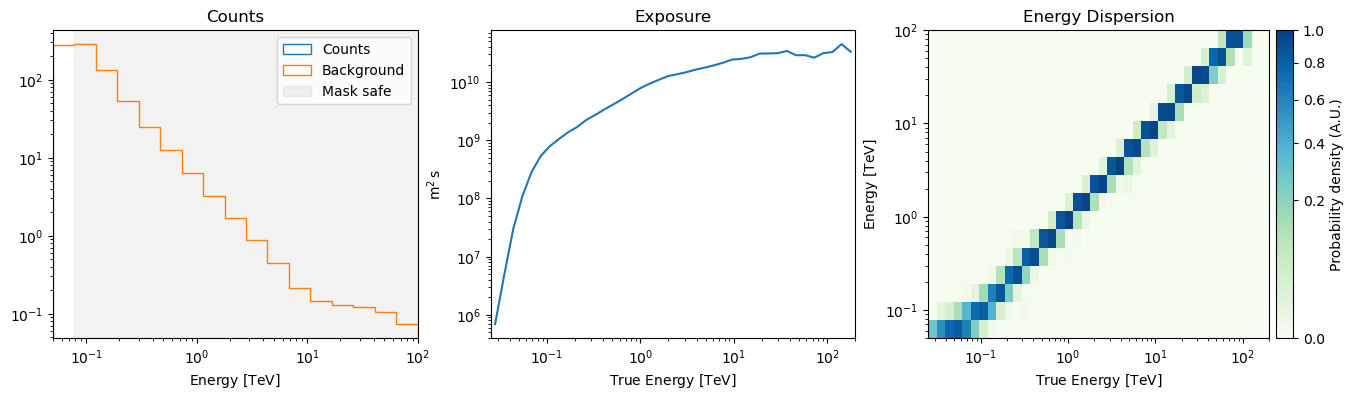

In [15]:
dataset.peek()

## Simulate datasets

### Model definition

Source models in gammapy are `SkyModel`. They are usually the combination of a `SpectralModel`, a `SpatialModel` and possibly a `TemporalModel`.

Here we only need a `SpectralModel`. It is the only mandatory component.

In [16]:
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel

In [17]:
spectral_model = LogParabolaSpectralModel(
        alpha=2.5,
        beta=0.25, 
        amplitude="3.8e-11 cm-2s-1TeV-1",
        reference="1 TeV",
    )

model = SkyModel(
    spectral_model=spectral_model,
    name="crab"
)

dataset.models = [model]
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset
---------------

  Name                            : obs-0 

  Total counts                    : 11486 
  Total background counts         : 523.04
  Total excess counts             : 10962.96

  Predicted counts                : 11529.86
  Predicted background counts     : 523.04
  Predicted excess counts         : 11006.81

  Exposure min                    : 6.90e+05 m2 s
  Exposure max                    : 4.50e+10 m2 s

  Number of total bins            : 17 
  Number of fit bins              : 16 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -142134.80

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      amplitude               

You can see that background counts are now simulated

 
## Create ON-OFF datasets


Since background maker was applied the datasets are regular datasets: i.e. they contain a background model but no acceptance ON and OFF nor OFF counts.

We have therefore to convert them to the proper format adding the required information. 

To do an on off spectral analysis, which is the usual science case, the standard would be to use SpectrumDatasetOnOff, which uses the acceptance to fake off-counts. 

We assume energy independent alpha_onoff=1/10:

In [18]:
dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
    dataset=dataset, acceptance=1, acceptance_off=10
)
dataset_on_off.fake(npred_background=dataset.npred_background())
print(dataset_on_off)

SpectrumDatasetOnOff
--------------------

  Name                            : 5RWWhmSn 

  Total counts                    : 11645 
  Total background counts         : 515.80
  Total excess counts             : 11129.20

  Predicted counts                : 11523.16
  Predicted background counts     : 516.35
  Predicted excess counts         : 11006.81

  Exposure min                    : 6.90e+05 m2 s
  Exposure max                    : 4.50e+10 m2 s

  Number of total bins            : 17 
  Number of fit bins              : 16 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 15.71

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : crab
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      amplitude      

You can see that off counts are now simulated as well. We now simulate several spectra using the same set of observation conditions.

In [19]:
n_sim = 100
simulated_datasets = Datasets()

for idx in range(n_sim):
    dataset_on_off.fake(random_state=idx, npred_background=dataset.npred_background())
    dataset_fake = dataset_on_off.copy(name=f"obs-{idx}")
    dataset_fake.meta_table["OBS_ID"] = [idx]
    simulated_datasets.append(dataset_fake)

We can browse the info_table

In [20]:
table = simulated_datasets.info_table()
display(table)

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
obs-0,11604,11081.7,189.20928226869836,522.3000000000001,1529.727272727273,1529.727272727273,nan,689615.7165769344,44973816104.46578,10800.0,10800.0,1.0744444444444445,0.04836111111111112,1.0260833333333335,17,16,wstat,41305.65840113013,5223,16.0,159.99999999999997,0.10000000000000002
obs-1,11284,10749.7,185.08024628998464,534.3000000000001,1511.5454545454545,1511.5454545454545,nan,689615.7165769344,44973816104.46578,10800.0,10800.0,1.0448148148148149,0.04947222222222223,0.9953425925925926,17,16,wstat,39939.919530201514,5343,16.0,159.99999999999997,0.10000000000000002
obs-2,11450,10927.3,187.5318167328534,522.6999999999999,1516.090909090909,1516.090909090909,nan,689615.7165769344,44973816104.46578,10800.0,10800.0,1.0601851851851851,0.04839814814814814,1.011787037037037,17,16,wstat,40635.81915726624,5227,16.0,160.0,0.09999999999999999
obs-3,11396,10871.1,186.8241238634615,524.9,1513.181818181818,1513.181818181818,nan,689615.7165769344,44973816104.46578,10800.0,10800.0,1.0551851851851852,0.04860185185185185,1.0065833333333334,17,16,wstat,40269.0850026788,5249,16.0,160.0,0.09999999999999999
obs-4,11665,11135.4,189.4485040595093,529.6,1541.909090909091,1541.909090909091,nan,689615.7165769344,44973816104.46578,10800.0,10800.0,1.0800925925925926,0.04903703703703704,1.0310555555555556,17,16,wstat,41288.75350425135,5296,16.0,160.0,0.1
obs-5,11464,10939.0,187.55224803043487,525.0000000000001,1519.4545454545453,1519.4545454545453,nan,689615.7165769344,44973816104.46578,10800.0,10800.0,1.0614814814814815,0.04861111111111112,1.0128703703703703,17,16,wstat,40592.45570400474,5250,16.0,159.99999999999997,0.10000000000000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
obs-94,11624,11101.3,189.40065837000105,522.6999999999999,1531.9090909090908,1531.9090909090908,nan,689615.7165769344,44973816104.46578,10800.0,10800.0,1.0762962962962963,0.04839814814814814,1.0278981481481482,17,16,wstat,41445.39342092938,5227,16.0,160.0,0.09999999999999999


Before moving on to the fit let’s have a look at the simulated observations.

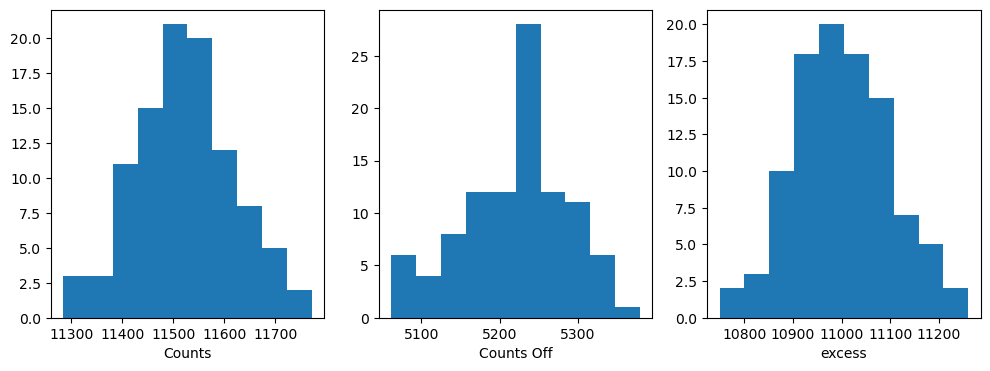

In [21]:
fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(table["counts"])
axes[0].set_xlabel("Counts")
axes[1].hist(table["counts_off"])
axes[1].set_xlabel("Counts Off")
axes[2].hist(table["excess"])
axes[2].set_xlabel("excess")
plt.show()

# Perform the fit

Here we fit a log parabola on the data and explore the distribution of parameters



Now, we fit each simulated spectrum individually

In [22]:
from gammapy.modeling import Fit

In [23]:
results = []
fit = Fit()

for dataset in simulated_datasets:
    # We use a copy of the simulated model
    dataset.models = [model.copy()]

    fit_result = fit.run([dataset])

    if fit_result.success:
        par_dict = {}
        for par in fit_result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results.append(par_dict)

In [24]:
fitted_params = Table(results).to_pandas()

In [25]:
mean = fitted_params.mean()
uncertainty = fitted_params.std()

for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {mean[name]:.2e} -+ {uncertainty[name]:.2e}")

amplitude :	 3.80e-11 -+ 4.66e-13
alpha :	 2.50e+00 -+ 1.34e-02
beta :	 2.49e-01 -+ 8.90e-03


We take a look at the distribution of the fitted alphas. This matches very well with the spectrum that we initially injected.

index: 2.4994 += 0.0133


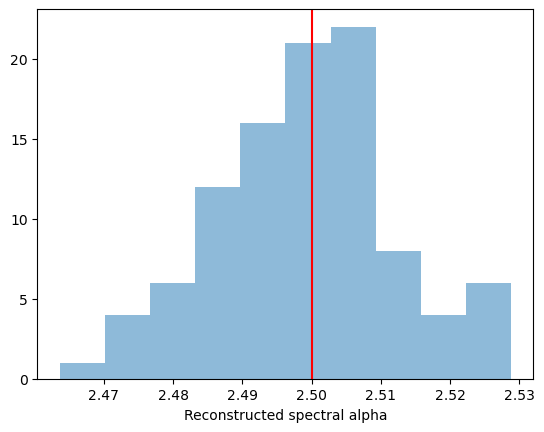

In [26]:
fig, ax = plt.subplots()
index = np.array([_["alpha"] for _ in results])
ax.hist(index, bins=10, alpha=0.5)
ax.axvline(x=spectral_model.parameters["alpha"].value, color="red")
ax.set_xlabel("Reconstructed spectral alpha")
print(f"index: {index.mean():.4f} += {index.std():.4f}")
plt.show()

# Exercise - advanced

## Exploring systematic effects: energy scale bias

### Step 1:  Create a biased log-parabola model

A systematic bias in the energy reconstruction that is not accounted for by the energy dispersion could have a significant impact of the fitted spectral parameters of the Crab nebula.

Use the possibility offered by gammapy to create a custom model to add a log parabola model with a systematic constant energy bias. This bias will come in addition to the one stored in the edisp and quantified by the shower simulations.


### Step 2:  Fake counts taking bias into account

Use the biased model and randomize the bias values. Then create the ON-OFF datasets and fake their content.

Assume a typical uncertainty on the energy scale of 3 percent.


### Step 3: Perform the fit

Fit a log parabola without a bias on the data and explore the distribution of parameters

In [27]:
from gammapy.modeling import Parameter
from gammapy.modeling.models import SpectralModel, LogParabolaSpectralModel

class BiasedLogParabolaSpectralModel(SpectralModel):
    tag = "BiasedLogParabolaSpectralModel"
    amplitude = Parameter("amplitude", "1e-12 cm-2 s-1 TeV-1", min=0, is_norm=True)
    alpha = Parameter("alpha", 2.5, min=0)
    beta = Parameter("beta", 0.5)
    reference = Parameter("reference", "1 TeV", frozen=True)
    bias = Parameter("bias", 1, min=0)
        
    @staticmethod
    def evaluate(energy, amplitude, alpha, beta, reference, bias):
        energy = bias.value * energy
        logpwl = LogParabolaSpectralModel.evaluate(
            energy=energy,
            alpha=alpha,
            beta=beta,
            amplitude=amplitude,
            reference=reference,
        )
        return logpwl

We can look at the resulting spectra. Obviously the impact on the amplitude is very significant.

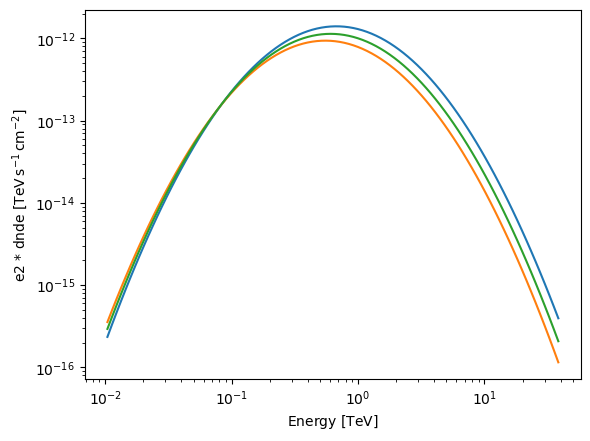

In [28]:
biased_spectral_model = BiasedLogParabolaSpectralModel()
biased_spectral_model.bias.value=0.9
ax = biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2)
biased_spectral_model.bias.value=1.1
biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2, ax=ax)
biased_spectral_model.bias.value=1.0
biased_spectral_model.plot([0.01,40]*u.TeV, energy_power=2, ax=ax);

In [29]:
biased_spectral_model = BiasedLogParabolaSpectralModel()

biased_spectral_model.alpha.value = spectral_model.alpha.value
biased_spectral_model.beta.value = spectral_model.beta.value
biased_spectral_model.amplitude.value = spectral_model.amplitude.value

In [30]:
biased_model = SkyModel(spectral_model=biased_spectral_model, name="biased_crab")

## Step 2: Fake counts taking bias into account

Here we use the biased model and randomize the bias values. We then create the ON-OFF datasets and fake their content.

We assume a typical uncertainty on the energy scale of 3 percent.

In [31]:
simulated_biased_datasets = Datasets()

for i in range(n_sim):
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
            dataset=dataset, acceptance=1, acceptance_off=10
    )
    # Randomize random bias
    biased_model.spectral_model.bias.value = np.random.normal(loc=1.0, scale=0.03)
    # Set the model on the ON-OFF dataset
    dataset_on_off.models = [biased_model]

    dataset_on_off.fake(npred_background=dataset.background)
    simulated_biased_datasets.append(dataset_on_off)

## Step 3: Perform the fit

Here we fit a log parabola without a bias on the data and explore the distribution of parameters

In [32]:
results_biased = []
fit = Fit()

for dataset in simulated_biased_datasets:
    # Use a copy of the simulated model
    dataset.models = [model.copy()]

    fit_result = fit.run([dataset])

    if fit_result.success:
        par_dict = {}
        for par in fit_result.parameters.free_parameters:
            par_dict[par.name] = par.quantity
        results_biased.append(par_dict)

In [33]:
fitted_params_with_energy_bias = Table(results_biased).to_pandas()
total_mean = fitted_params_with_energy_bias.mean()
total_uncertainty = fitted_params_with_energy_bias.std()

In [34]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+ {total_uncertainty[name]:.2e}")

amplitude :	 3.79e-11 -+ 3.09e-12
alpha :	 2.50e+00 -+ 1.91e-02
beta :	 2.52e-01 -+ 7.77e-03




To separate statistics from systematics we assume the total uncertainty is the quadratic sum of statistic and systematic errors.


In [35]:
systematic_uncertainty = np.sqrt(total_uncertainty**2 - uncertainty**2)

/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [36]:
for name in ['amplitude', 'alpha', 'beta']:
    print(f"{name} :\t {total_mean[name]:.2e} -+\t"
          f" {uncertainty[name]:.2e} (stat) -+\t"
          f" {systematic_uncertainty[name]:.2e} (sys)")

amplitude :	 3.79e-11 -+	 4.66e-13 (stat) -+	 3.05e-12 (sys)
alpha :	 2.50e+00 -+	 1.34e-02 (stat) -+	 1.36e-02 (sys)
beta :	 2.52e-01 -+	 8.90e-03 (stat) -+	 nan (sys)
